In [193]:
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve, f1_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
import catboost as catb

import pickle
import dill

# Цифровой Прорыв

## Хакатон "Медицина, здравоохраниение, наука"

## Кейс "Разработка детектора ковидных аномалий в ритме сердца"

В рамках соревнования участникам необходимо научиться находить специфичные для
COVID-19 аномалии в измерениях сердечного ритма человека. Для этого вам предоставлен
набор данных (train.csv), в которых искомые временные интервалы отмечены экспертами. 

Качество модели оценивается на отложенной выборке с помощью F1-score. Тестовый набор
данных без целевой переменной (test.csv)
будет предоставлен участникам

Основной файл
- `train.csv` обучающая выборка со следующими столбцами:  
   - **id** - идентификатор временного ряда сердечного ритма
   - **time** - время в ms ( миллисекунды)
   - **x** - R-R интервал
   - **y** - признак разметки ковидной аномалии

In [2]:
FILE_DATA = 'data/train.csv'

In [3]:
df = pd.read_csv(FILE_DATA)

In [4]:
df

,id,time,x,y
0,1,0,800,0
1,1,780,780,0
2,1,1572,792,0
3,1,2392,820,0
4,1,3196,804,0
...,...,...,...,...
60482,275,115360,552,0
60483,275,115912,552,0
60484,275,116464,552,0
60485,275,117020,556,0


Посмотрим на R-R интервалы нескольких пациентов:

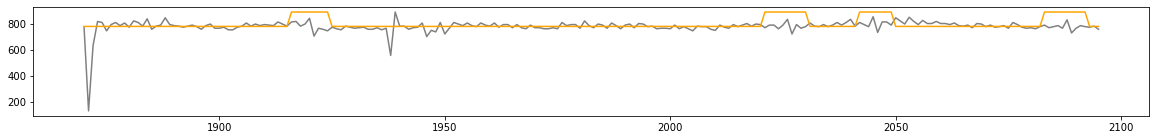

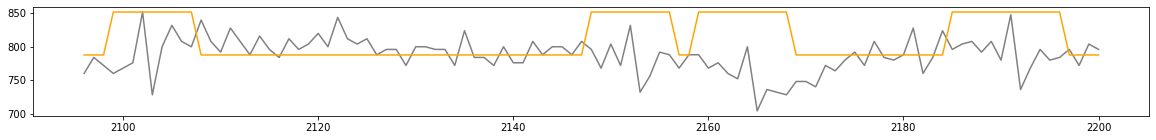

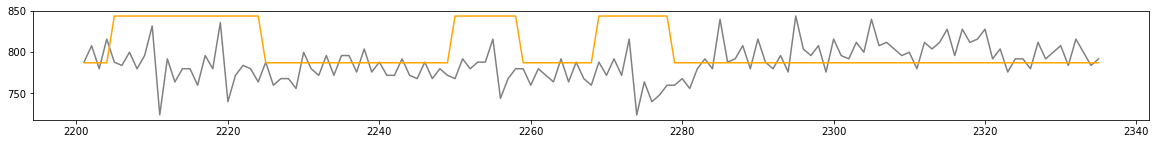

In [5]:
for patient in df.id.unique()[1:4]:
    
    figure(figsize=(20,2))
    mean_interval = df.loc[df.id==patient, 'x'].mean()
    max_interval = df.loc[df.id==patient, 'x'].max()
    plt.plot(df.loc[df.id==patient, 'x'], color='grey')
    plt.plot(df.loc[df.id==patient, 'y']*(max_interval-mean_interval) + mean_interval, color='orange')
    plt.show()

Как видно, в размеченных областях наблюдается определенный паттерн ковидной аномалии: интервал сначала увеличивается, потом резко уменьшается, а далее снова приходит к среднему сердечному ритму. Далее паттерн аномалии покажу более подробно.

Для удобства анализа создадим вспомогательную фичу 'marked_area', который будет показывать номер маркированного участка в датасете.

In [6]:
df['marked_area'] = (df['y'] != df['y'].shift())
df['marked_area'] = np.where(df['y'] == 0, np.nan, df['marked_area'])
df['marked_area'] = df['marked_area'].cumsum().fillna(0).astype(np.int32)
df

,id,time,x,y,marked_area
0,1,0,800,0,0
1,1,780,780,0,0
2,1,1572,792,0,0
3,1,2392,820,0,0
4,1,3196,804,0,0
...,...,...,...,...,...
60482,275,115360,552,0,0
60483,275,115912,552,0,0
60484,275,116464,552,0,0
60485,275,117020,556,0,0


Покажем паттерн подробнее на примере 26-го маркированного участка:

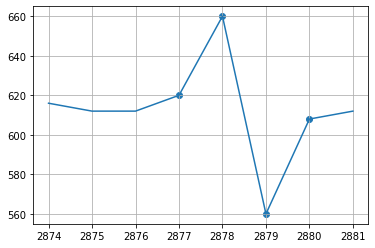

In [7]:
plt.plot(df.loc[df.marked_area==26, 'x'])
plt.scatter(np.arange(2877,2881), df.loc[df.marked_area==26, 'x'].iloc[3:7])
plt.grid()
plt.show()

Таким образом, паттерн можно описать 4-мя точками: первая и последняя равны тренду, вторая и третья - этапы резкого увеличения и резкого снижения ритма.

Как видно, участки захватывают не только сам паттерн, но и некоторое произвольное количество интервалов слева и справа, т.к. разметка производилась вручную врачами. В контексте машинного обучения же удобнее предсказывать в виде таргета одну из точек паттерна, проходя окном по датасету. Значит для построения модели необходимо создать дополнительный таргет с переразмеченным признаком ковидной аномалии, который будет содержать одну из точек паттерна (а значит по этой точке можно будет идентифицировать и весь паттерн).

Таким образом, решение задачи разбивается на несколько этапов:
- Сделать дополнительный таргет, идентифицировав одну из точек паттерна в размеченном участке.
- Обучить модель на новый таргет, проходя окном по датасету.
- Для предсказания маркированных участков дополнить предсказанный таргет итервалами слева и справа. Это сделать можно либо просто подобрав оптимальные интервалы фиксированной длины, либо обучив модель регрессии.

## Переразметка датасета

Для идентификации одной из точек паттерна сделаем следующие действия:
- Введем фичу 'x_SMA_5' - скользящее среднее по пяти значениям для каждого размеченного участка. Первые 5 значений тренда будут скользящим средним от одного до пяти значений соответственно.
- Создадим вспомогательный датасет, где для каждого размеченного участка посчитаем минимальное min_value_per_trend и максимальное max_value_per_trend значение отношения 'x' к тренду. Предполагаем, что эти значения и есть 2-я и 3-я точка паттерна.
- Исследуем распределение min_value_per_trend и max_value_per_trend, а затем по этим значениям выделим 2-ю или 3-ю точку паттерна.

Введем фичу 'x_SMA_5' - скользящее среднее по пяти значениям для каждого размеченного участка:

In [8]:
df['x_SMA_5'] = df.groupby(df['marked_area'])['x'].transform(lambda x: x.rolling(5, 1).mean())
# немаркированные участки также оказались заполнены скользящим средним, но нам нужна линия тренда только для маркированных

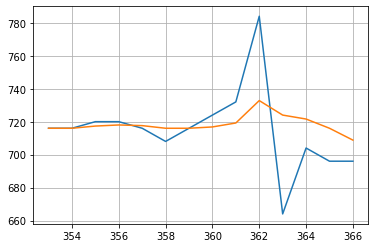

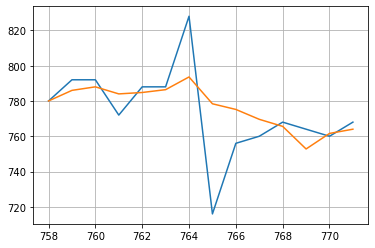

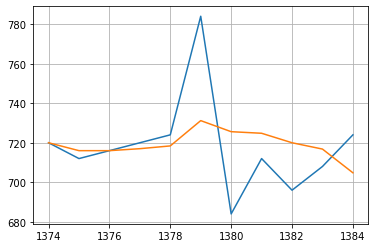

In [9]:
for itm in range(1, 4):
    plt.plot(df.loc[df.marked_area==itm, 'x'])
    plt.plot(df.loc[df.marked_area==itm, 'x_SMA_5'])
    plt.grid()
    plt.show()

Создадим дополнительный датасет для исследования отношения 'x' к тренду:

In [10]:
columns = ['id', 'count_ser', 'min_value_per_trend', 'max_value_per_trend']
index = [idx for idx in df.marked_area.unique() if idx]
df_target = pd.DataFrame(columns=columns, index=index)
for col in columns:
    df_target[col] = 0
df_target

,id,count_ser,min_value_per_trend,max_value_per_trend
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
5,0,0,0,0
...,...,...,...,...
787,0,0,0,0
788,0,0,0,0
789,0,0,0,0
790,0,0,0,0


In [11]:
df['value_per_trend'] = df['x'] / df['x_SMA_5']

In [12]:
df_target['id'] = df.groupby(df.marked_area)['id'].agg(lambda x: x.iloc[0]).iloc[1:]
df_target['count_ser'] = df.groupby(df.marked_area)['y'].agg('sum').iloc[1:]
df_target['min_value_per_trend'] = df.groupby(df.marked_area)['value_per_trend'].agg('min').iloc[1:]
df_target['max_value_per_trend'] = df.groupby(df.marked_area)['value_per_trend'].agg('max').iloc[1:]

In [13]:
df_target

,id,count_ser,min_value_per_trend,max_value_per_trend
1,1,14,0.917127,1.069869
2,1,14,0.919836,1.043347
3,1,11,0.942668,1.072210
4,2,9,0.894309,1.038576
5,2,10,0.925926,1.051567
...,...,...,...,...
787,273,10,0.913838,1.074646
788,275,12,0.927694,1.057951
789,275,10,0.908460,1.064407
790,275,12,0.912209,1.063257


Посмотрим распределения для каждой из фичей:

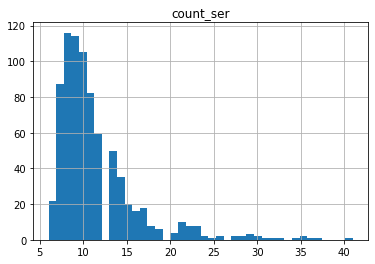

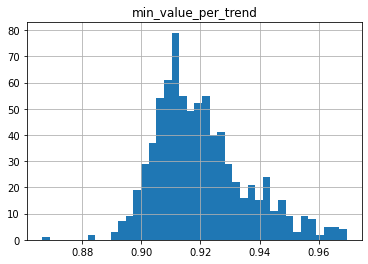

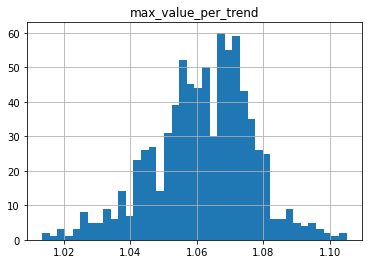

In [14]:
cols = df_target.columns.tolist()
cols.pop(0)
for col in cols:
    df_target[col].hist(bins=40)
    plt.title(col)
    plt.show()

- count_ser - Видно, что длина некоторых маркированных участков достигает 40 значений. В длинных участках присутствует более одного паттерна.
- min_value_per_trend - Максимальное значение этого признака ограничено значением 0.97. Соответственно, взяв это значение в качестве отсечки, можно идентифицировать 3-ю точку паттерна.
- max_value_per_trend - Минимальное значение этого признака ограничено значением 1.01. Соответственно, взяв это значение в качестве отсечки, можно идентифицировать 2-ю точку паттерна.

Теперь выделим 3-ю точку паттерна и создадим новый таргет 'y2':

In [15]:
condition = (df['marked_area'] > 0) & (df['value_per_trend'] < 0.97) & (df['value_per_trend'].shift() > 1.01)
df['y2'] = np.where(condition, 1, 0)

Посмотрим некоторые выделенные паттерны:

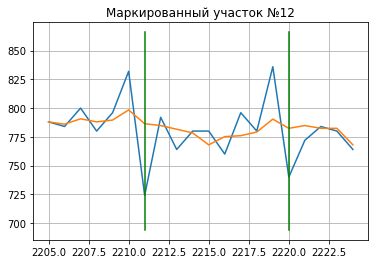

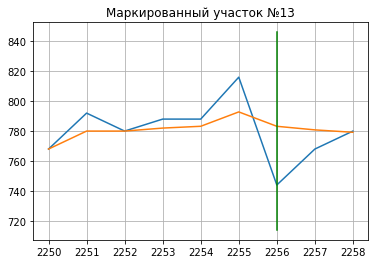

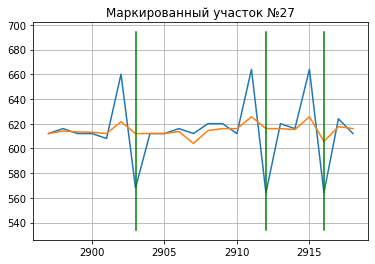

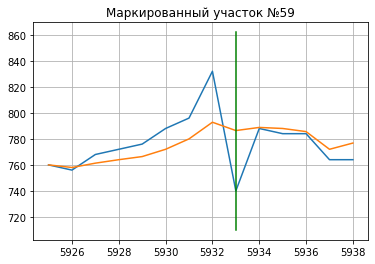

In [16]:
for idx in [12, 13, 27, 59]:
    tmp = df.loc[df['marked_area'] == idx]
    idx2 = tmp.loc[tmp['y2']==1].index
    min_max = np.linspace(tmp.x.min()-30, tmp.x.max()+30, 10)
    plt.plot(tmp['x'])
    plt.plot(tmp['x_SMA_5'])
    for target in idx2:
        plt.plot([target]*10, min_max, color='green')
    plt.title(f'Маркированный участок №{idx}')
    plt.grid()
    plt.show()

Как видно, удалось выделить минимумы паттернов в маркированных участках. Найдем маркированные участки, в которых не удалось выделить паттерны и визуализируем их:

In [17]:
count_pattern = df.groupby(df.marked_area)['y2'].agg('sum').iloc[1:]
count_pattern.loc[count_pattern==0]

marked_area
33     0
66     0
414    0
Name: y2, dtype: int32

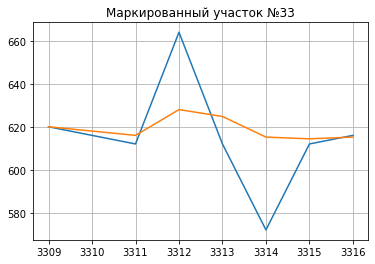

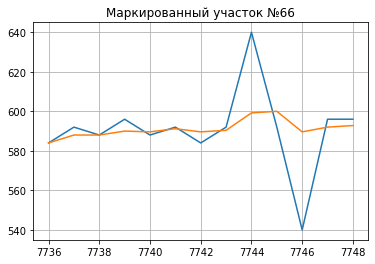

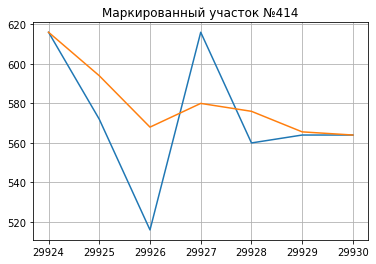

In [18]:
for idx in [33, 66, 414]:
    tmp = df.loc[df['marked_area'] == idx]
    idx2 = tmp.loc[tmp['y2']==1].index
    min_max = np.linspace(tmp.x.min()-30, tmp.x.max()+30, 10)
    plt.plot(tmp['x'])
    plt.plot(tmp['x_SMA_5'])
    for target in idx2:
        plt.plot([target]*10, min_max, color='green')
    plt.title(f'Маркированный участок №{idx}')
    plt.grid()
    plt.show()

Маркированные участки 33 и 66 похожи на паттерн внешне, но у них между максимумом и минимумом есть еще одна точка, примерно лежащая на тренде. Участок 414 же совсем не похож на паттерн. Так как таких участка всего 3 на 791, можно предположить, что это человеческий фактор, ошибка врача, который размечал эти области. Вручную размечать эти 3 области не стоит, так как это будет обучение на неверных данных и лишь ухудшит работу модели.

Подводя итог, можно сказать, что удалось очень хорошо переразметить датасет.

## Обучение модели

Обучать модель на новый таргет 'y2' будем, проходя окном по датасету. То есть нашими признаками для обучения будут признак 'x' и несколько значений от текущего 'x' слева и справа. Наибольшую важность будут иметь ближайшие от 'x' признаки, то есть точки паттерна. По мере удаления от 'x' важность признаков будет падать. Необходимую ширину окна подберем, обучая модель.

Для начала возьмем большую ширину окна в 21 значение - по 10 значений слева и справа от 'x'. Заполним признаки с помощью метода shift, получившиеся пропуски заполним нулями.

In [19]:
for idx in range(1, 11):
    left_feat_name = 'left_shift_' + str(idx)
    right_feat_name = 'right_shift_' + str(idx)
    df[left_feat_name] = df.groupby(df.id)['x'].transform(lambda x: x.shift(idx))
    df[right_feat_name] = df.groupby(df.id)['x'].transform(lambda x: x.shift(-idx))
    df[left_feat_name].fillna(0, inplace=True)
    df[right_feat_name].fillna(0, inplace=True)
df

,id,time,x,y,marked_area,x_SMA_5,value_per_trend,y2,left_shift_1,right_shift_1,...,right_shift_6,left_shift_7,right_shift_7,left_shift_8,right_shift_8,left_shift_9,right_shift_9,left_shift_10,right_shift_10,max-min
0,1,0,800,0,0,800.000000,1.000000,0,0.0,780.0,...,916.0,0.0,960.0,0.0,956.0,0.0,928.0,0.0,836.0,-800.0
1,1,780,780,0,0,790.000000,0.987342,0,800.0,792.0,...,960.0,0.0,956.0,0.0,928.0,0.0,836.0,0.0,792.0,20.0
2,1,1572,792,0,0,790.666667,1.001686,0,780.0,820.0,...,956.0,0.0,928.0,0.0,836.0,0.0,792.0,0.0,776.0,-12.0
3,1,2392,820,0,0,798.000000,1.027569,0,792.0,804.0,...,928.0,0.0,836.0,0.0,792.0,0.0,776.0,0.0,736.0,-28.0
4,1,3196,804,0,0,799.200000,1.006006,0,820.0,828.0,...,836.0,0.0,792.0,0.0,776.0,0.0,736.0,0.0,724.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60482,275,115360,552,0,0,554.400000,0.995671,0,504.0,552.0,...,0.0,556.0,0.0,560.0,0.0,560.0,0.0,1120.0,0.0,-48.0
60483,275,115912,552,0,0,554.400000,0.995671,0,552.0,552.0,...,0.0,560.0,0.0,556.0,0.0,560.0,0.0,560.0,0.0,0.0
60484,275,116464,552,0,0,552.800000,0.998553,0,552.0,556.0,...,0.0,560.0,0.0,560.0,0.0,556.0,0.0,560.0,0.0,0.0
60485,275,117020,556,0,0,543.200000,1.023564,0,552.0,552.0,...,0.0,552.0,0.0,560.0,0.0,560.0,0.0,556.0,0.0,-4.0


Выделим признаки для обучения. Закомментированные признаки - это признаки, которые были выкинуты в процессе обучения модели

In [20]:
learn_cols = ['x', 
              'left_shift_1', 
              'left_shift_2', 
              'left_shift_3',
              'left_shift_4', 
#               'left_shift_5', 
#               'left_shift_6', 
#               'left_shift_7',
              'right_shift_1', 
              'right_shift_2', 
              'right_shift_3', 
              'right_shift_4', 
#               'right_shift_5', 
#               'right_shift_6', 
             ]

Посмотрим плотность распределения каждого признака в зависимости от таргета и доверительные интервалы средних значений признака в зависимости от таргета.

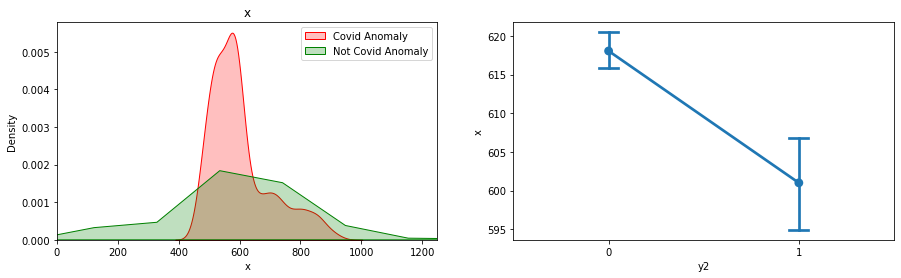

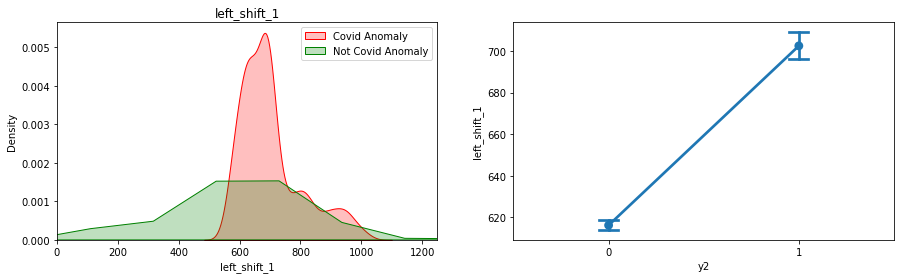

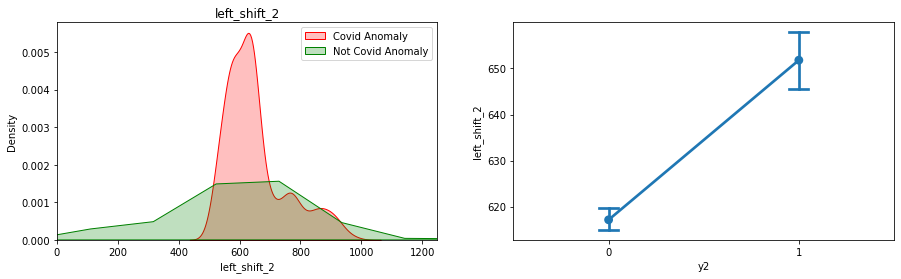

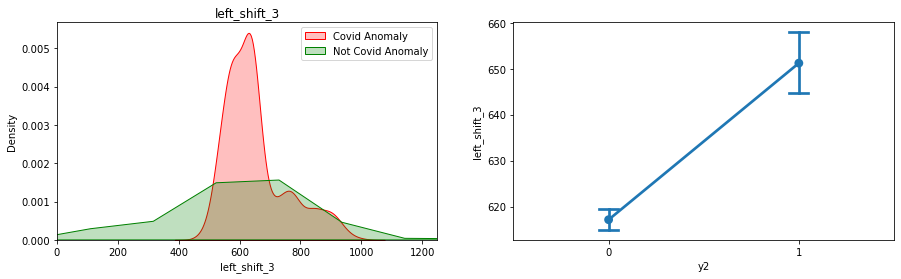

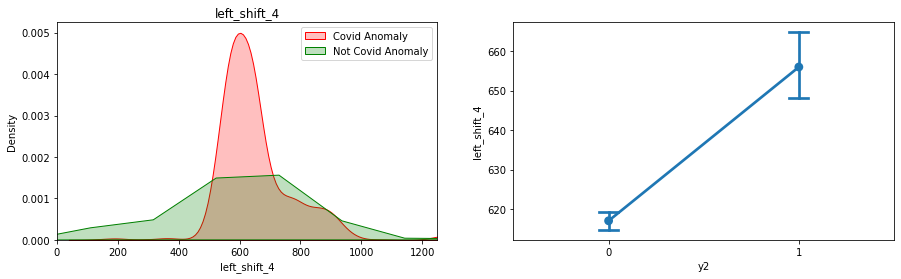

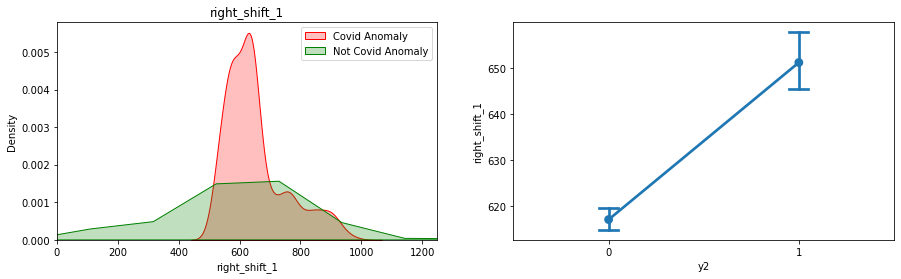

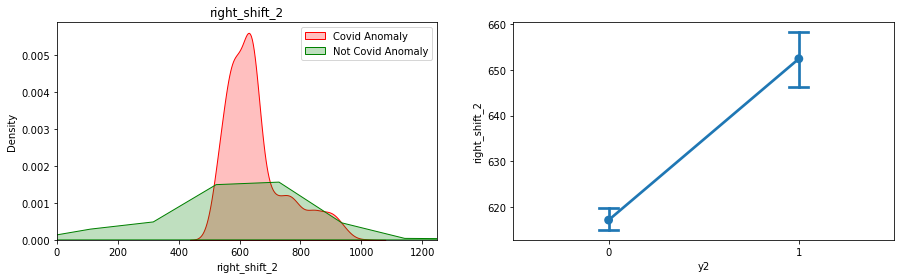

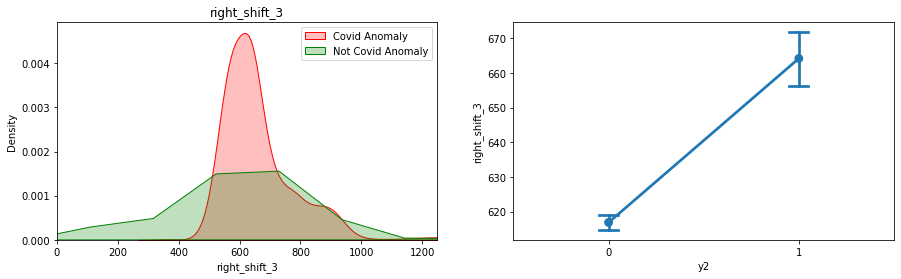

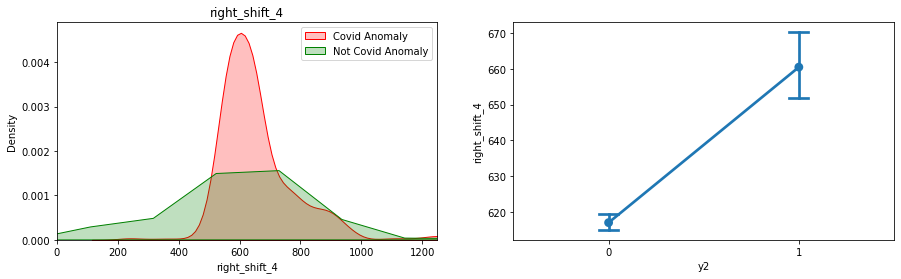

In [21]:
for itm in learn_cols:
    plt.figure(figsize=(15,4))
    plt.subplot(121)
    sns.kdeplot(df.loc[df['y2'] == 1, itm], shade=True, label='Covid Anomaly', color='r')
    sns.kdeplot(df.loc[df['y2'] == 0, itm], shade=True, label='Not Covid Anomaly', color='g')
    plt.legend()
    plt.xlim(0, 1250)
    plt.title(itm)
    plt.subplot(122)
    sns.pointplot(x=df['y2'], y=df[itm], capsize=.1)
    plt.show()

Как видно, каждый признак имеет разное распределение в зависимости от таргета, а доверительные интервалы средних значений не пересекаются. То есть таргет по этим признакам хорошо разделим.

Так как теперь для каждого измерения у нас в признаках представлены предыдущие и последующие значения, мы можем не относиться к нашему датасету, как к временному ряду. И можем спокойно перемешать и разделить датасет с помощью train_test_split. Разобьем выборку на тренировочную и валидационную:

In [22]:
X = df[learn_cols]
y = df['y2']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, 
                                                      shuffle=True, 
                                                      stratify=y, 
                                                      random_state=21)

Напишем функции для представления отчета классификации:

In [23]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [24]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

Вычислим дизбаланс классов:

In [25]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

56.76261937244202

Запишем неизменяемые параметры модели в словарь:

In [26]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':42,
     'eval_metric':'F1',
     'early_stopping_rounds':50
}

Произведем поиск по сетке двух параметров - глубины дерева и количества деревьев в бустинге:

In [27]:
params = {'iterations':[100, 200, 300],
          'max_depth':[7,8,9,10]}

cv = StratifiedKFold(n_splits=5, random_state=21, shuffle=True)

model_catb = catb.CatBoostClassifier(**frozen_params)
grid_search = model_catb.grid_search(params, X, y, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.9818856379
bestIteration = 74

0:	loss: 0.9818856	best: 0.9818856 (0)	total: 5.36s	remaining: 59s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9828129543
bestIteration = 101

1:	loss: 0.9828130	best: 0.9828130 (1)	total: 12.7s	remaining: 1m 3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9828129543
bestIteration = 101

2:	loss: 0.9828130	best: 0.9828130 (1)	total: 20.6s	remaining: 1m 1s

bestTest = 0.9832772696
bestIteration = 94

3:	loss: 0.9832773	best: 0.9832773 (3)	total: 26.9s	remaining: 53.8s

bestTest = 0.9859166989
bestIteration = 197

4:	loss: 0.9859167	best: 0.9859167 (4)	total: 39s	remaining: 54.6s

bestTest = 0.9879055888
bestIteration = 296

5:	loss: 0.9879056	best: 0.9879056 (5)	total: 57.1s	remaining: 57.1s

bestTest = 0.981658568
bestIteration = 99

6:	loss: 0.9816586	best: 0.9879056 (5)	total: 1m 6s	remaining: 47.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9833669785
bestIteration = 

![CardioSpike2](grid_search_clf.png "grid_search")

In [28]:
grid_search['params']

{'depth': 10, 'iterations': 300}

Обучим модель, используя лучшие параметры:

In [29]:
catb_model = catb.CatBoostClassifier(**frozen_params, iterations=300, max_depth=10)
catb_model.fit(X_train, y_train, plot=True, eval_set=(X_valid, y_valid))

evaluate_preds(catb_model, X_train, X_valid, y_train, y_valid)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     41607
           1       0.74      1.00      0.85       733

    accuracy                           0.99     42340
   macro avg       0.87      1.00      0.92     42340
weighted avg       1.00      0.99      0.99     42340

TEST

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     17833
           1       0.63      1.00      0.77       314

    accuracy                           0.99     18147
   macro avg       0.82      0.99      0.88     18147
weighted avg       0.99      0.99      0.99     18147

CONFUSION MATRIX

col_0      0    1
y2               
0      17652  181
1          1  313


![CardioSpike2](catb_model.png "catboost")

Подберем порог, при котором метрика f1 будет максимальной:

In [30]:
y_score = catb_model.predict_proba(X_valid)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_valid, y_score)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.912528, F-Score=0.871, Precision=0.830, Recall=0.917


Мы получили метрику f1-score 0.871, что является очень хорошим результатом для классификации.

Посмотрим на важность признаков:

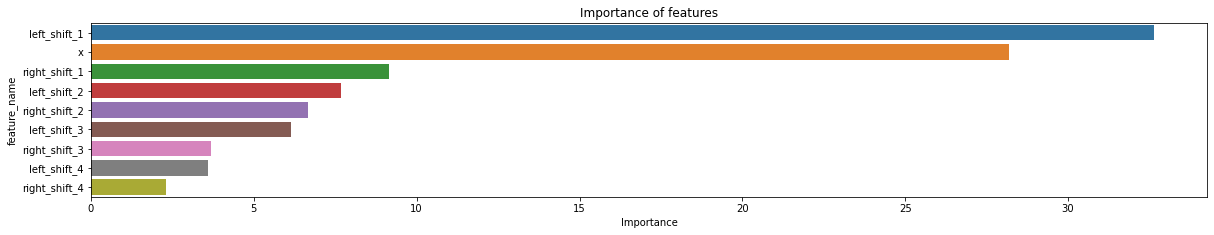

In [31]:
feature_importances = pd.DataFrame(zip(X_train.columns, catb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
sns.barplot(feature_importances['importance'], feature_importances['feature_name'])
    
plt.xlabel('Importance')
plt.title('Importance of features')
plt.show()

Как я и говорил выше, наибольшую важность имею те признаки, которые находятся ближе к 'x'.

Посмотрим и проанализируем ошибки первого и второго рода, которые допустила модель:

In [32]:
y_valid_pred = np.where(y_score >= thresholds[ix], 1, 0)
y_valid_pred = pd.Series(y_valid_pred, index=X_valid.index)

Найдем индексы ошибок второго рода:

In [33]:
err_2 = ((y_valid == 0) & (y_valid_pred == 1)) 
err_2 = err_2.loc[err_2].index.tolist()
len(err_2)

59

Посмотрим графики первых 10 ошибок:

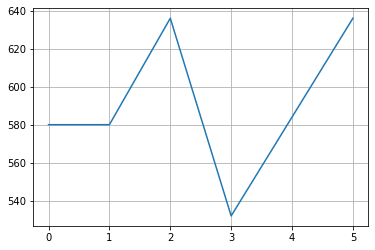

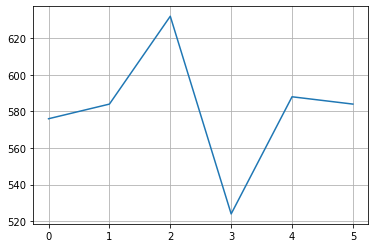

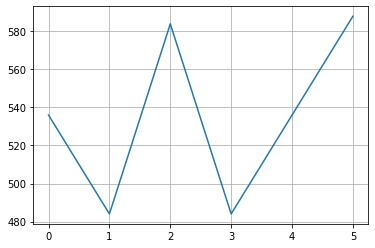

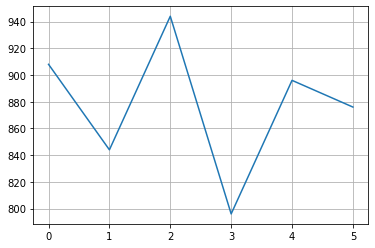

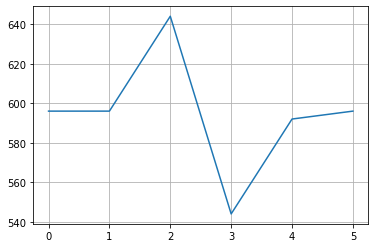

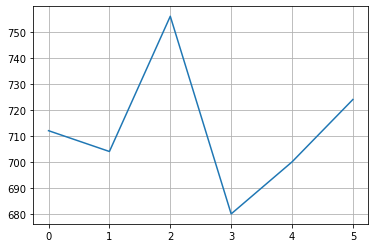

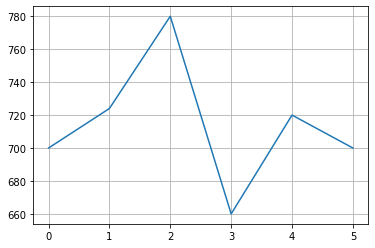

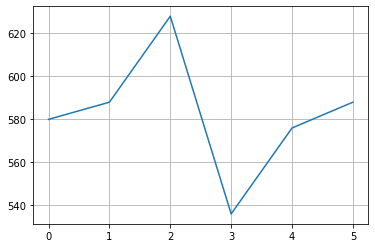

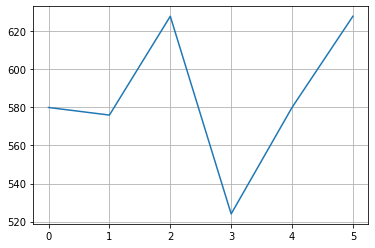

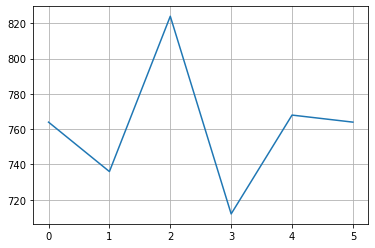

In [34]:
for i in err_2[:10]:
    st = X_valid.loc[i]
    st2 = []
    st2.append(st['left_shift_3'])
    st2.append(st['left_shift_2'])
    st2.append(st['left_shift_1'])
    st2.append(st['x'])
    st2.append(st['right_shift_1'])
    st2.append(st['right_shift_2'])
    plt.plot(range(6), st2)
    plt.grid()
    plt.show()

Теперь посмотрим графики первых десяти ошибок первого рода:

In [36]:
err_1 = ((y_valid == 1) & (y_valid_pred == 0)) 
err_1 = err_1.loc[err_1].index.tolist()
len(err_1)

26

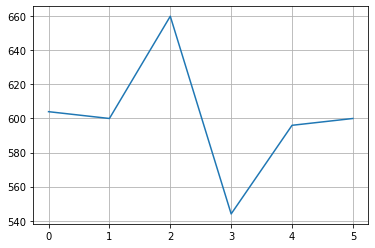

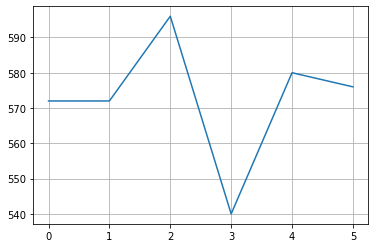

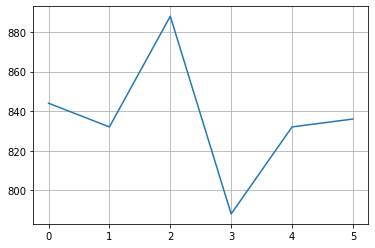

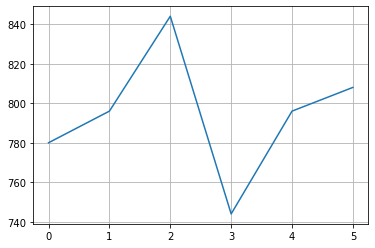

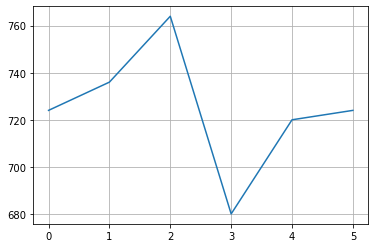

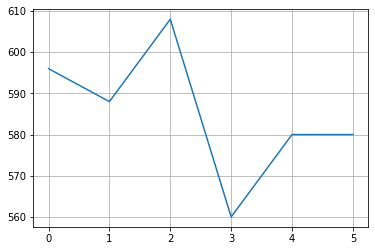

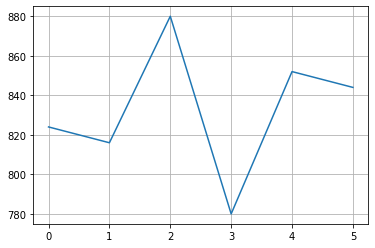

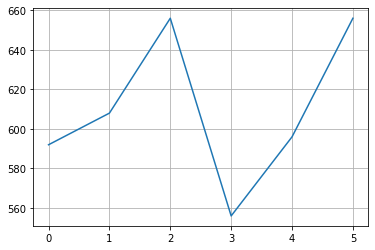

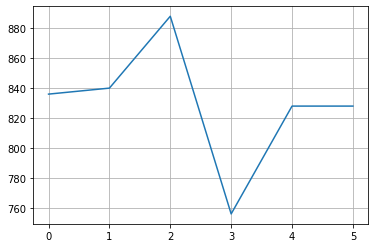

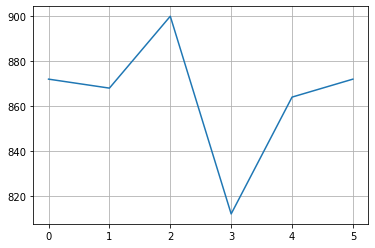

In [38]:
for i in err_1[:10]:
    st = X_valid.loc[i]
    st2 = []
    st2.append(st['left_shift_3'])
    st2.append(st['left_shift_2'])
    st2.append(st['left_shift_1'])
    st2.append(st['x'])
    st2.append(st['right_shift_1'])
    st2.append(st['right_shift_2'])
    plt.plot(range(6), st2)
    plt.grid()
    plt.show()

#### Выводы по ошибкам первого и второго рода:

- До изменения порога предсказания имели практически 100% recall, но низкий, 63%, precsion. Возможно, это говорит о том, что на самом деле модель выявила больше паттернов, чем обнаружили врачи.
- Представленные графики ошибок второго рода также говорят в пользу этого - они очень напоминают паттерн, а минимальные и максимальные значения, их разброс, лежит в пределах значений для паттерна.
- После изменения порога для предсказаний recall немного снизился. И на графиках ошибок первого рода мы видим, что отсечнные порогом измерения также очень похожи на паттерн аномалии.
- Таким образом, из-за неидеальной разметки и требования получить максимальный f1-score мы вынуждены снижать recall, повышая precsion. Хотя, конечно, не мне судить о точности разметки врачами сердечных ритмограмм =).

Сохраним нашу модель:

In [39]:
pkl_clf_filename = "pickle_clf_model.pkl"
with open(pkl_clf_filename, 'wb') as file:
    pickle.dump(catb_model, file)

In [194]:
with open("dill_clf_model.dill", "wb") as f:
    dill.dump(catb_model, f)

## Восстановление маркированных участков вокруг предсказанного таргета

Попробуем для начала восстановить маркированные участки участками фиксированной длины. Для этого в местах, где таргет у2 = 1, заполним единицами фиксированное количество наблюдений слева и справа, и посчитаем метрику f1. Так проделаем для нескольких размеров участка, чтобы найти максимальную метрику и подобрать оптимальный размер фиксированного участка.

In [77]:
for k in range(3, 10):
    y3 = pd.Series(np.sum([df['y2'].shift(i).fillna(0) for i in range(-k, k)], axis=0), index=df.index)
    y3 = np.where(y3 >= 1, 1, 0)
    print(f'Для фиксированной ширины участка в {k} наблюдений слева и справа f1_score будет: {f1_score(df.y, y3)}')

Для фиксированной ширины участка в 3 наблюдений слева и справа f1_score будет: 0.8073186959414503
Для фиксированной ширины участка в 4 наблюдений слева и справа f1_score будет: 0.8954778666030307
Для фиксированной ширины участка в 5 наблюдений слева и справа f1_score будет: 0.911418609718893
Для фиксированной ширины участка в 6 наблюдений слева и справа f1_score будет: 0.8819412978905503
Для фиксированной ширины участка в 7 наблюдений слева и справа f1_score будет: 0.8354644603234299
Для фиксированной ширины участка в 8 наблюдений слева и справа f1_score будет: 0.7894666961717194
Для фиксированной ширины участка в 9 наблюдений слева и справа f1_score будет: 0.7493600772103562


Создадим конвеер, который будет делать feature engineering для классификации, предсказывать по сохраненной модели минимум паттерна и дополнять паттерн фиксированными интервалами слева и справа:

In [304]:
class Pipeline:
    
    def __init__(self, dill_clf_filename):
        self.clf_learn_cols = ['x', 'left_shift_1', 'left_shift_2', 'left_shift_3', 'left_shift_4', 
              'right_shift_1', 'right_shift_2', 'right_shift_3', 'right_shift_4']
        self.dill_clf_filename = dill_clf_filename
        with open(self.dill_clf_filename, 'rb') as f:
            self.clf_model = dill.load(f)
        self.df = None
        self.index = None
        self.threshold = 0.912528
        
        # Имеет смысл добавить:
        # self.regr_learn_cols = [...] - необходимые фичи для предикта регрессии
        # self.pkl_regr_filename = pkl_regr_filename - путь сохраненной модели регрессии
    
    def clf_transformation(self, X):
        self.df = X.copy()
        self.index = self.df.index
        for idx in range(1, 5):
            left_feat_name = 'left_shift_' + str(idx)
            right_feat_name = 'right_shift_' + str(idx)
            self.df[left_feat_name] = self.df.groupby(self.df.id)['x'].transform(lambda x: x.shift(idx))
            self.df[right_feat_name] = self.df.groupby(self.df.id)['x'].transform(lambda x: x.shift(-idx))
            self.df[left_feat_name].fillna(0, inplace=True)
            self.df[right_feat_name].fillna(0, inplace=True)
    
    def clf_predict(self):
        y = self.clf_model.predict_proba(self.df[self.clf_learn_cols])[:, 1]
        y = np.where(y >= self.threshold, 1, 0)
        y = pd.Series(y, index=self.index)
        self.df['y2'] = y
    
    def regr_transformation(self):
        """
        Здесь делаем необходимый feature engineering для задачи регрессии.
        Сгенерированные фичи для регрессии вносим в self.df
        Пример:
        df = self.df.copy()
        feat1 = some_func(df)
        .
        .
        feat_n = some_func_n(df)
        self.df['feat1'], .., self.df['feat_n'] = feat1, .., feat_n
        """
        pass
    
    def predict(self, X):
        self.clf_transformation(X)
        self.clf_predict()
        # self.regr_transformation()
        """
        Далее следует мой код, который потом следует заменить регрессионной моделью.
        Модель также не стоит обучать в конвеере, а загрузить из pickle уже обученную.
        Пример:
        with open(self.pkl_regr_filename, 'rb') as f:
            regr_model = pickle.load(f)
        y = regr_model.predict(self.df[self.regr_learn_cols])
        y = pd.Series(y, index=self.index).apply(round, 1) # значения регрессии нужно будет округлить
        return y
        """
        y = np.sum([self.df['y2'].shift(i).fillna(0) for i in range(-5, 5)], axis=0)
        y = pd.Series(np.where(y >= 1, 1, 0), index=self.index)
        
        # Получаем словарь диагнозов diagnosis_by_id. Ключи - id пациента, значения - диагнозы. True - болен, False - здоров
        diagnosis = self.df.groupby(self.df.id)['y2'].agg(lambda x: True if x.sum() > 0 else False).tolist()
        diagnosis_by_id = dict(zip(self.df.id.unique().tolist(), diagnosis))
        
        # Получаем словарь кастомной метрики - количество аномалий за 5 минут. Ключи - id пациента, значения - количество аномалий
        tmp_df = self.df.groupby(self.df.id, as_index=False).agg({'x': 'sum', 'y2': 'sum'})
        tmp_df['pattern_per_5minute'] = tmp_df.y2 * 300000 / tmp_df.x
        tmp_df['pattern_per_5minute'] = tmp_df['pattern_per_5minute'].apply(round)
        pattern_per_5minute = dict(zip(tmp_df.id, tmp_df.pattern_per_5minute))
        
        return y, diagnosis_by_id, pattern_per_5minute

In [191]:
finall_model = Pipeline("pickle_clf_model.pkl")
pkl_finall_filename = "pickle_finall_model.pkl"
with open(pkl_finall_filename, 'wb') as file:
    pickle.dump(finall_model, file)

In [305]:
finall_model = Pipeline("dill_clf_model.dill")
dill_finall_filename = "dill_finall_model.dill"
with open(dill_finall_filename, 'wb') as file:
    dill.dump(finall_model, file)

Загрузим еще раз датасет и разобьем его на 2 примерно в отношении 1:2:

In [175]:
df = pd.read_csv(FILE_DATA)

df_train = pd.DataFrame(columns=df.columns).astype(np.int32)
df_test = pd.DataFrame(columns=df.columns).astype(np.int32)
for itm in df['id'].unique():
    if itm%3 == 2:
        df_test = pd.concat([df_test, df.loc[df['id'] == itm]])
    else:
        df_train = pd.concat([df_train, df.loc[df['id'] == itm]])

Посмотрим f1_score для каждой части, и для всего датасета в целом:

In [300]:
# with open(pkl_finall_filename, 'rb') as f:
#             finall_model = pickle.load(f)
finall_model = Pipeline("dill_clf_model.dill")
# y_pred = finall_model.predict(df_test)

In [186]:
f1_score(df_test.y, y_pred)

0.8714173844949099

In [117]:
y_pred2 = finall_model.predict(df_train)
f1_score(df_train.y, y_pred2)

0.8299277922876018

In [301]:
y_pred3, diagnosis, pattern_per_5minute = finall_model.predict(df)
# f1_score(df.y, y_pred3)

In [302]:
pattern_per_5minute

{1: 1,
 2: 9,
 3: 11,
 4: 11,
 5: 8,
 6: 7,
 7: 14,
 10: 17,
 12: 13,
 13: 8,
 14: 6,
 15: 9,
 16: 9,
 17: 11,
 19: 5,
 20: 2,
 21: 2,
 22: 2,
 23: 3,
 24: 8,
 25: 6,
 27: 11,
 29: 26,
 30: 16,
 31: 29,
 32: 17,
 33: 26,
 34: 45,
 35: 33,
 36: 22,
 38: 27,
 39: 39,
 40: 28,
 41: 18,
 42: 20,
 43: 26,
 44: 17,
 45: 18,
 46: 11,
 47: 37,
 48: 25,
 49: 22,
 51: 36,
 52: 29,
 53: 26,
 54: 15,
 55: 27,
 57: 23,
 58: 53,
 59: 36,
 60: 13,
 61: 11,
 62: 19,
 63: 16,
 64: 21,
 65: 23,
 66: 25,
 67: 23,
 68: 25,
 69: 23,
 70: 15,
 71: 11,
 72: 15,
 73: 34,
 74: 37,
 75: 16,
 76: 12,
 77: 14,
 78: 30,
 79: 24,
 80: 29,
 82: 21,
 84: 46,
 85: 17,
 86: 26,
 87: 15,
 88: 14,
 89: 12,
 90: 14,
 91: 42,
 92: 39,
 93: 21,
 96: 53,
 97: 15,
 99: 16,
 100: 29,
 101: 26,
 102: 24,
 103: 18,
 104: 15,
 107: 3,
 108: 3,
 109: 4,
 110: 19,
 111: 15,
 112: 18,
 113: 12,
 115: 9,
 116: 8,
 117: 16,
 118: 17,
 119: 12,
 120: 7,
 121: 33,
 122: 10,
 123: 8,
 124: 9,
 125: 22,
 126: 44,
 127: 2,
 128: 13,
 129: 

Теперь сделаем предсказания для каждого пациента в отдельности и посмотрим распределение метрик:

In [151]:
metrics_by_id = []
for i in df.id.unique():
    X = df.loc[df.id == i]
    y_pred = finall_model.predict(X)
    metrics_by_id.append(f1_score(X.y, y_pred))
    if f1_score(X.y, y_pred) < 0.6:
        bad.append(i)
    elif 0.6 < f1_score(X.y, y_pred) < 0.75:
        middle.append(i)

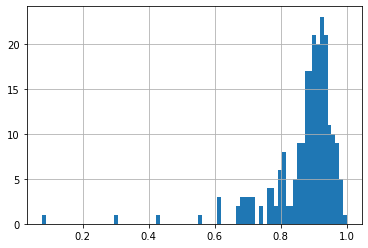

In [126]:
metrics_by_id = pd.Series(metrics_by_id)
metrics_by_id.hist(bins=80)
plt.show()

Как видно, в основном значения лежат от 0.8 до 1, но есть 4 аномальных значения меньше 0.6, одно даже меньше 0.1. Но, в большинстве случаев, модель очень хорошо работает.

In [202]:
df2 = df.copy()
df2['y_pred'] = y_pred3

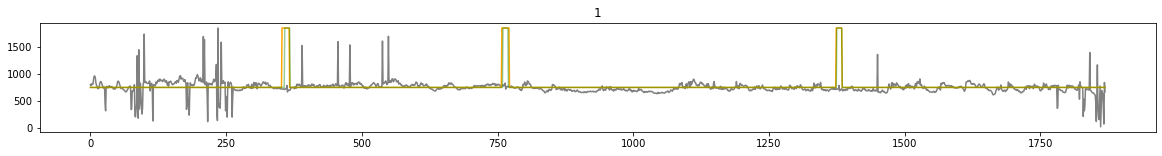

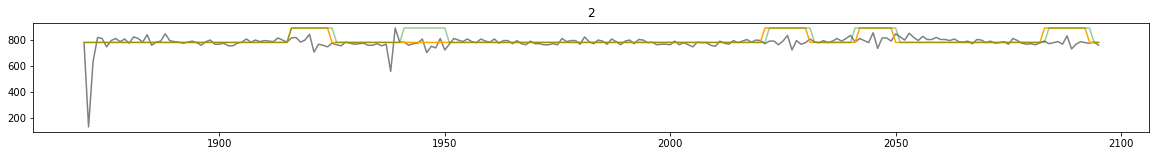

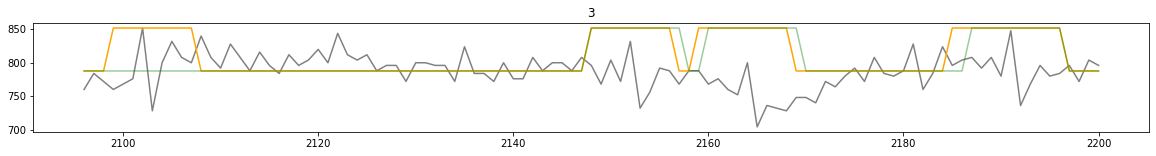

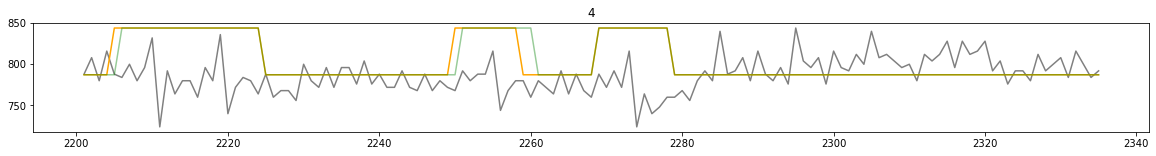

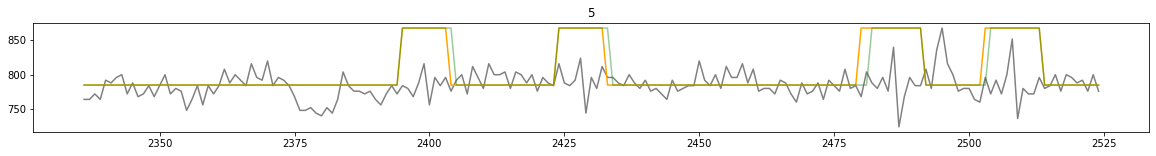

In [251]:
for patient in df2.id.unique()[0:5]:
    
    figure(figsize=(20,2))
    mean_interval = df2.loc[df2.id==patient, 'x'].mean()
    max_interval = df2.loc[df2.id==patient, 'x'].max()
    plt.plot(df2.loc[df2.id==patient, 'x'], color='grey')
    plt.plot(df2.loc[df2.id==patient, 'y']*(max_interval-mean_interval) + mean_interval, color='orange')
    plt.plot(df2.loc[df2.id==patient, 'y_pred']*(max_interval-mean_interval) + mean_interval, color='green', alpha=.4)
    plt.title(patient)
    plt.show()

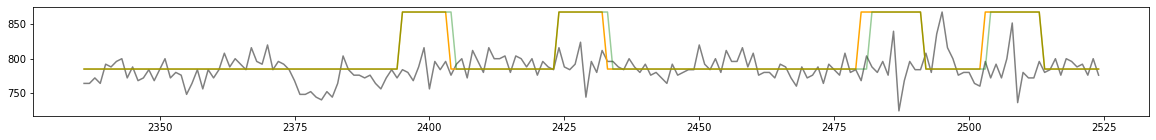

In [220]:
df3 = df2.loc[df2.id==5]
figure(figsize=(20,2))
mean_interval = df3.x.mean()
max_interval = df3.x.max()
plt.plot(df3.x, color='grey')
plt.plot(df3.y*(max_interval-mean_interval) + mean_interval, color='orange')
plt.plot(df3.y_pred*(max_interval-mean_interval) + mean_interval, color='green', alpha=.4)
plt.show()

In [221]:
df3.drop(columns='y_pred', inplace=True)
df3

,id,time,x,y
2336,5,0,764,0
2337,5,764,764,0
2338,5,1536,772,0
2339,5,2300,764,0
2340,5,3092,792,0
...,...,...,...,...
2520,5,144444,788,0
2521,5,145236,792,0
2522,5,146012,776,0
2523,5,146812,800,0


In [222]:
df3.to_csv('patient_3_anomaly.csv', index=False)

In [223]:
df3 = pd.read_csv('patient_3_anomaly.csv')
df3

,id,time,x,y
0,5,0,764,0
1,5,764,764,0
2,5,1536,772,0
3,5,2300,764,0
4,5,3092,792,0
...,...,...,...,...
184,5,144444,788,0
185,5,145236,792,0
186,5,146012,776,0
187,5,146812,800,0
